# Phishing dataset
### What to test
##### For all methods:
- Metric: precision, accuracy
- holdout, cross-Validation (mean)

##### Methods:
- kNN(2-5), L1 and L2 norm
- Random forest (num trees = ???) (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier) https://mljar.com/blog/how-many-trees-in-random-forest/
 - naive bayes (https://scikit-learn.org/stable/modules/classes.html?highlight=naive%20bayes#module-sklearn.naive_bayes)
    
 ### Structure
 One function to get training + test sets depending on holdout or cross-validation <br>
 One function to train and test for all data splits for a given model <br>
     *Returns (mean) precision, accuracy for holdout/ cross-validation. <br>
     
 One cell for each method

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import time

import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#load data, shuffle and separate parameters from labels
df_raw = pd.read_csv("data/phpV5QYya.csv")
num_entries = df_raw.shape[0]
num_attributes = df_raw.shape[1]
df_shuffeled = df_raw.sample(frac=1,random_state=193520285)
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(df_shuffeled)
df_shuffeled = scaler.transform(df_shuffeled)

X = df_shuffeled[:,:-1]
Y = df_shuffeled[:,-1:]

#Create splits
cross_validator10 = skl.model_selection.StratifiedKFold(n_splits=10)
hX_train, hX_test, hY_train, hY_test = skl.model_selection.train_test_split(X,Y, test_size=0.2)

df_raw

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


0.5569425599276345


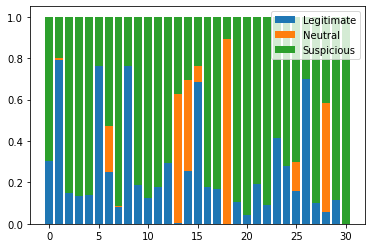

In [5]:
# Plot characteristics of data set

df_temp = df_raw[df_raw["Result"]==1]
length_df = df_temp.shape[0]

print(length_df/num_entries)

num_legitimate = np.count_nonzero(df_temp == -1, axis=0)/length_df
num_neutral    = np.count_nonzero(df_temp == 0, axis=0)/length_df
num_suspect    = np.count_nonzero(df_temp == 1, axis=0)/length_df

plt.bar(range(0,num_attributes), num_legitimate)
plt.bar(range(0,num_attributes), num_neutral, bottom = num_legitimate)
plt.bar(range(0,num_attributes), num_suspect, bottom = num_legitimate + num_neutral)

plt.legend(["Legitimate", "Neutral", "Suspicious"])

plt.savefig("ex1-plots/phishing/distribution_suspect")

## Prepare evaluation functions 

In [6]:
def evaluateModelFromDataset(model, X_train, Y_train, X_test, Y_test):
    start = time.time()
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    delta = (time.time()-start)/len(Y_test)*1000
    
    report = skl.metrics.classification_report(Y_test,Y_pred, output_dict=True)
    
    #Reports precision of phishing links, total accuracy and the time delta fitting and classifying took per test sample (ms)
    return report['1.0']['precision'], report['accuracy'], delta

def evaluateModel(model, do_print = True):

    #Test holdout
    holdout_rep = evaluateModelFromDataset(model, hX_train, hY_train.flatten(), hX_test, hY_test)
    
    #Test cross-evaluation
    report_precision = []
    report_accuracy  = []
    report_time = []
    for train_index, test_index in cross_validator10.split(X,Y):
        X_train = X[train_index]
        Y_train = Y[train_index]
        X_test  = X[test_index]
        Y_test  = Y[test_index]
        
        rep = evaluateModelFromDataset(model, X_train, Y_train.flatten(), X_test, Y_test)
        report_precision.append(rep[0])
        report_accuracy.append(rep[1])
        report_time.append(rep[2])
    
    if(do_print):
        print(f"Holdout precision: {holdout_rep[0]}, accuracy: {holdout_rep[1]}")
        print(f"Cross-evaluation average precision: {np.mean(report_precision)}, std: {np.std(report_precision)}")
        print(f"Cross-evaluation average accuracy: {np.mean(report_accuracy)}, std: {np.std(report_accuracy)}")
        print(f"Holdout time: {holdout_rep[2]}, cross-evaluation mean time: {np.mean(report_time)}, std: {np.std(report_time)}")
    return [holdout_rep[0], np.mean(report_precision)], [holdout_rep[1], np.mean(report_accuracy)], [holdout_rep[2], np.mean(report_time)]

## kNN

In [7]:
# perform kNN for different norms and k's

precisions = []
accuracies = []
times = []
ks = range(2,6)
for k in ks:
    kNN_L1 = kNN(n_neighbors=k, p=1)
    kNN_L2 = kNN(n_neighbors=k, p=2)
    
    print(f"-- k={k}, L1 --")
    repL1 = evaluateModel(kNN_L1)
    
    print(f"-- k={k}, L2 --")
    repL2 = evaluateModel(kNN_L2)
    
    precisions.append(repL1[0] + repL2[0])
    accuracies.append(repL1[1] + repL2[1])
    times.append(repL1[2] + repL2[2])
    
    
print("Done!")
    


-- k=2, L1 --
Holdout precision: 0.9776490066225165, accuracy: 0.9579375848032564
Cross-evaluation average precision: 0.9765457624604489, std: 0.003104173758146621
Cross-evaluation average accuracy: 0.9577572762308428, std: 0.006444423509748466
Holdout time: 0.2181228066612185, cross-evaluation mean time: 0.26801435817082275, std: 0.040840198375999635
-- k=2, L2 --
Holdout precision: 0.971737323358271, accuracy: 0.9493441881501583
Cross-evaluation average precision: 0.9763750476628271, std: 0.003986868023437379
Cross-evaluation average accuracy: 0.9498877369837906, std: 0.004833689603970898
Holdout time: 0.1343880665889966, cross-evaluation mean time: 0.1294676347839466, std: 0.010948387391344348
-- k=3, L1 --
Holdout precision: 0.9556259904912837, accuracy: 0.9561284486657621
Cross-evaluation average precision: 0.9551594972656204, std: 0.004244937334269767
Cross-evaluation average accuracy: 0.9589330922242315, std: 0.00444778876962642
Holdout time: 0.29250638401923484, cross-evaluatio

<Figure size 432x288 with 0 Axes>

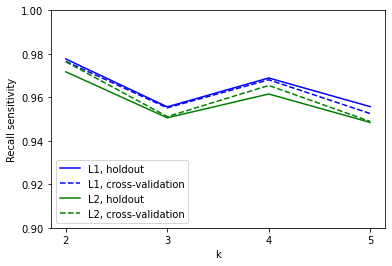

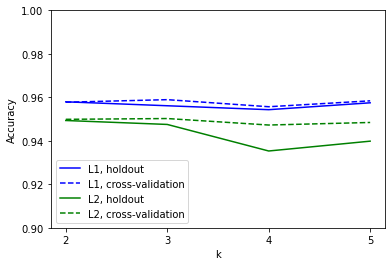

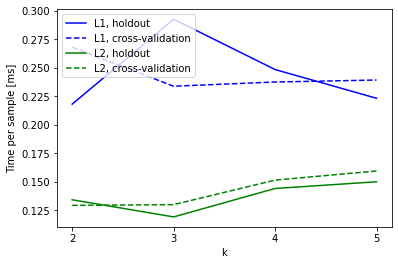

In [8]:
# plot kNN-findings

precisionsT = np.transpose(precisions)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["L1, holdout", "L1, cross-validation", "L2, holdout", "L2, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(precisionsT)):
    plt.plot(ks, precisionsT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Recall sensitivity')
plt.legend(legends, loc = "lower left")

plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNprecision.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(ks, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(legends, loc = "lower left")
plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNaccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(ks, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/phishing/kNNtime")




## LDA

In [9]:
# calculate LDA
lda = LinearDiscriminantAnalysis(solver='eigen')

evaluateModel(lda)


Holdout precision: 0.9200626959247649, accuracy: 0.9208502939846224
Cross-evaluation average precision: 0.9174468107312244, std: 0.009081903429168791
Cross-evaluation average accuracy: 0.9213029710423605, std: 0.004621694486023774
Holdout time: 0.021152612797440795, cross-evaluation mean time: 0.02083901926389476, std: 0.0029134410604085116


([0.9200626959247649, 0.9174468107312244],
 [0.9208502939846224, 0.9213029710423605],
 [0.021152612797440795, 0.02083901926389476])

In [10]:
# plot LDA

## Random forest

In [11]:
# calculate random forest for different number of forests/ different split measurements
num_trees = [1,2,4,6,8,10, 20, 50, 100, 200]

precisions = []
accuracies = []
times = []
for n in num_trees:
    
    print(f"-- Gini, Num trees: {n} --")
    randomForestGini = RandomForestClassifier(n_estimators = n, criterion="gini")
    repGini = evaluateModel(randomForestGini)
    
    print(f"-- Entropy, Num trees: {n} --")
    randomForestEntropy = RandomForestClassifier(n_estimators = n, criterion="entropy")
    repEntropy = evaluateModel(randomForestEntropy)
    
    precisions.append(repGini[0] + repEntropy[0])
    accuracies.append(repGini[1] + repEntropy[1])
    times.append(repGini[2] + repEntropy[2])
    
print("Done!")
    

-- Gini, Num trees: 1 --
Holdout precision: 0.9589371980676329, accuracy: 0.9516056083220262
Cross-evaluation average precision: 0.9542068619587216, std: 0.010199492033896222
Cross-evaluation average accuracy: 0.9478057162494988, std: 0.00875729564074654
Holdout time: 0.003165758772168101, cross-evaluation mean time: 0.006512678215859195, std: 0.00036195398230899243
-- Entropy, Num trees: 1 --
Holdout precision: 0.9471191791633781, accuracy: 0.9484396200814111
Cross-evaluation average precision: 0.9517247516151638, std: 0.007009206865855511
Cross-evaluation average accuracy: 0.9483491936209733, std: 0.007037273333963863
Holdout time: 0.0031656509392512756, cross-evaluation mean time: 0.0055558163168117946, std: 0.000608840258065025
-- Gini, Num trees: 2 --
Holdout precision: 0.9780405405405406, accuracy: 0.9479873360470376
Cross-evaluation average precision: 0.971126301829343, std: 0.006147748580125057
Cross-evaluation average accuracy: 0.9492548255913855, std: 0.007244799937535626
Hol

<Figure size 432x288 with 0 Axes>

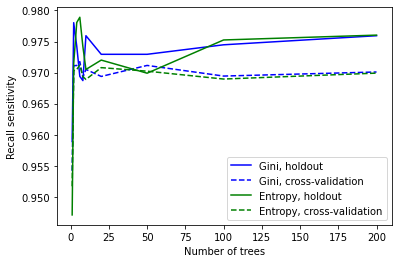

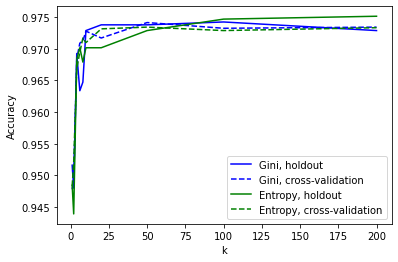

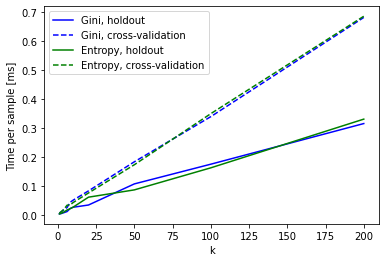

In [12]:
# plot random forest

# plot kNN-findings
precisionsT = np.transpose(precisions)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','g-', 'g--']
legends = ["Gini, holdout", "Gini, cross-validation", "Entropy, holdout", "Entropy, cross-validation"]

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(precisionsT)):
    plt.plot(num_trees, precisionsT[i],colorScheme[i]) 

plt.xlabel('Number of trees')
plt.ylabel('Recall sensitivity')
plt.legend(legends, loc = "lower right")

#plt.ylim([0.96,1])

plt.savefig("ex1-plots/phishing/RandomForestSensitivity.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(num_trees, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend(legends, loc = "lower right")
#plt.ylim([0.96,1])

plt.savefig("ex1-plots/phishing/RandomForestAccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(num_trees, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')
plt.legend(legends, loc = "upper left")

plt.savefig("ex1-plots/phishing/RandomForestTime")




In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


train, test =  train_test_split(df_raw, test_size=0.2)

from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(train.drop(["Result"],axis=1), train["Result"])



RandomForestClassifier(random_state=0)

In [29]:
probas=forest.predict_proba(test.drop(["Result"],axis=1))
predictions=forest.predict(test.drop(["Result"],axis=1))


from sklearn.metrics import confusion_matrix

confusion_matrix(test["Result"], predictions)
tn, fp, fn, tp = confusion_matrix(test["Result"], predictions).ravel()
(tn, fp, fn, tp)

(954, 38, 22, 1197)

In [17]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.011 seconds


In [32]:
tp/(tp+fp)

0.9692307692307692

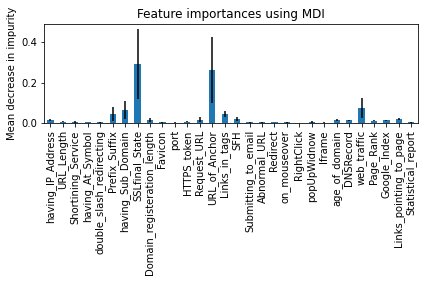

In [26]:
import pandas as pd

forest_importances = pd.Series(importances, index=test.drop(["Result"],axis=1).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()